# Project 5DEEP (Deep Learning) 
### Hugo Huygens - Matteo Gora

### Importation des librairies

In [131]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers, models
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from keras.applications import MobileNetV2




### Importation des datasets

In [132]:
train_data = pd.read_csv('./datasets/sign_mnist_train.csv')
test_data = pd.read_csv('./datasets/sign_mnist_test.csv')

### Transformation des images en 28 x 28 pixels.

Ici on affiche un échantillon de 25 images car plus pourrait être beaucoup trop lourd 

### Séparation des labels et des caractéristiques
Ici, nous séparons les données en deux ensembles : les caractéristiques (les pixels des images) et les labels (les classes cibles).
Le label correspond à la lettre de l'alphabet en langue des signes, et chaque image est représentée par 784 pixels (28x28).
Nous utilisons la méthode drop() pour enlever la colonne 'label' des données d'entraînement et de test, 
car cette colonne ne contient pas de pixels mais les classes cibles.

In [133]:
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

### Normalisation des données (les valeurs de pixels entre 0 et 1)
Les images sont codées en niveaux de gris avec des valeurs de pixels allant de 0 à 255.
Pour faciliter l'apprentissage des modèles de machine learning et améliorer la convergence du modèle,
il est courant de normaliser les données afin que les valeurs de pixels soient comprises entre 0 et 1.
Cela se fait en divisant chaque valeur de pixel par 255.

In [134]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Reshape des données en images 28x28 pixels
Après la normalisation, nous redimensionnons les données pour qu'elles correspondent à leur véritable forme d'image 28x28.
Chaque image est initialement une longue série de 784 pixels (28x28), nous utilisons donc la méthode reshape() 
pour structurer ces pixels sous forme de matrices 2D représentant les images.
Le dernier paramètre "1" représente le nombre de canaux, ici il s'agit d'images en niveaux de gris, donc un seul canal.

In [135]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

### Affichage des dimensions des jeux de données
Nous affichons ici la forme des données d'entraînement et de test pour nous assurer que tout a été correctement chargé et redimensionné.

In [136]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (27455, 28, 28, 1)
Test data shape: (7172, 28, 28, 1)


### Fonction pour afficher un lot d'images
Cette fonction affiche un ensemble d'images (défini par batch_size) avec leurs labels respectifs.
Nous utilisons la bibliothèque matplotlib pour visualiser les images.
La fonction parcourt chaque image dans un lot et les affiche dans une grille (5x5 pour 25 images par défaut).

In [137]:
def display_images(data, labels, batch_size=25, start_index=0):
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[start_index + i], cmap='gray')
        plt.title(f"Label: {labels[start_index + i]}")
    plt.show()

### Affichage du premier lot d'images
Nous appelons la fonction display_images pour afficher les premières 25 images du jeu de données d'entraînement
Cela permet de visualiser les exemples d'images et de vérifier que les données ont été correctement chargées et formatées.
Charger plus d'images pourrait alourdir l'exécution du programme et provoquer des ralentissements

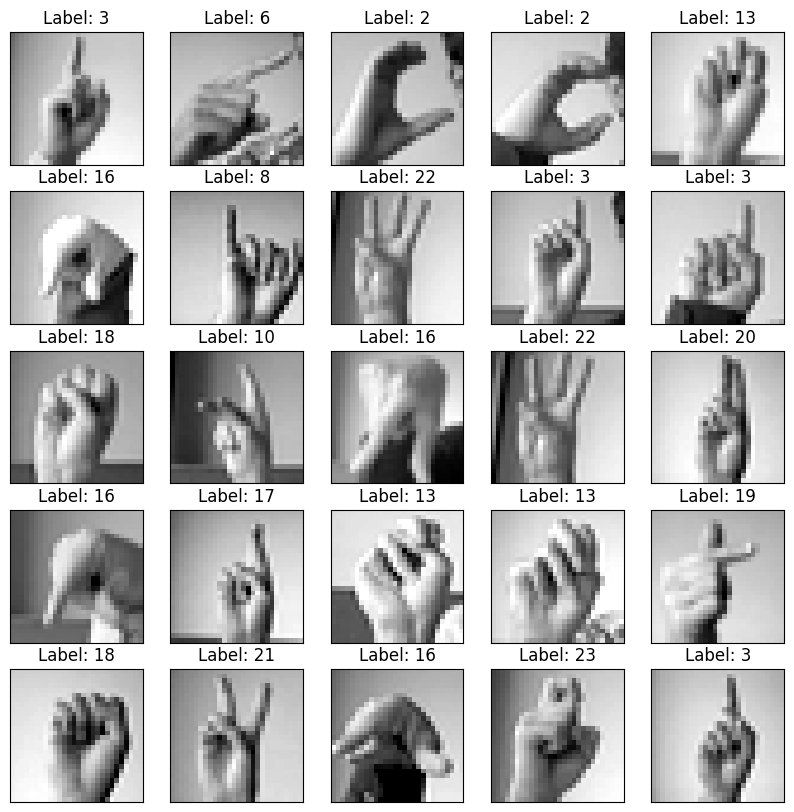

In [138]:
display_images(X_train, y_train, batch_size=25, start_index=0)

### 2 Ce dataset est-il équilibré ? Est-il nécessaire de rééquilibrer les données ? Le faire si besoin est.
Le dataset d'entraînement présente une distribution des classes relativement homogène, bien que certaines classes aient un peu plus d'exemples que d'autres. Par exemple, la classe 16 contient 1 279 exemples, tandis que la classe 4 n'en contient que 957. Néanmoins, aucune classe ne semble être dramatiquement sous-représentée au point de nécessiter un rééquilibrage des données par sur-échantillonnage ou sous-échantillonnage.

Le dataset de test présente une distribution similaire à celle de l'entraînement, mais avec des variations plus notables. Par exemple, la classe 4 possède 498 exemples, alors que la classe 17 n'en a que 144. Cependant, cela ne semble pas poser de problème significatif pour l'entraînement du modèle.

En résumé, bien que les datasets ne soient pas parfaitement équilibrés, ils ne nécessitent pas de rééquilibrage spécifique, car les écarts de distribution entre les classes ne sont pas extrêmement importants.

### Réseau de neurones convolutif

Ce modèle de réseau de neurones convolutif (CNN) prend en entrée des images de 28x28 pixels, applique des couches de convolution pour extraire des caractéristiques, les réduit avec des couches de pooling, puis passe par des couches complètement connectées pour effectuer la classification en 24 classes avec une sortie softmax pour fournir les probabilités.

In [139]:
def create_cnn_model(input_shape=(28, 28, 1), num_classes=25, optimizer='adam', dropout_rate=0.5, neurons=128):
    model = models.Sequential()

    model.add(Input(shape=input_shape))
    # First convolutional layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Third convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Flatten and fully connected layers
    model.add(layers.Flatten())

    # Dense layer with customizable number of neurons and regularization (optional)
    model.add(layers.Dense(neurons, activation='relu'))

    # Dropout layer
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,825 (518.85 KB)

 Trainable params: 132,825 (518.85 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du modèle construit à la question précédente et mesure de sa performance.

In [140]:
# Entraîner le modèle
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, 
                        validation_data=(X_test, y_test))

# Évaluer le modèle sur les données de test
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

print(f'Accuracy on test set: {test_acc:.4f}')


Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3089 - loss: 2.2599 - val_accuracy: 0.8402 - val_loss: 0.5294
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8613 - loss: 0.4056 - val_accuracy: 0.8971 - val_loss: 0.3478
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9423 - loss: 0.1675 - val_accuracy: 0.9090 - val_loss: 0.2901
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9665 - loss: 0.0979 - val_accuracy: 0.9311 - val_loss: 0.2682
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9778 - loss: 0.0668 - val_accuracy: 0.9318 - val_loss: 0.2590
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9827 - loss: 0.0506 - val_accuracy: 0.9275 - val_loss: 0.2934
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9823 - loss: 0.0515 - val_accuracy: 0.9339 - val_loss: 0.3080
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9849 - loss: 0.0422 - val_accuracy: 0.

### Affichages des courbes d'évolution de la précision et de la perte

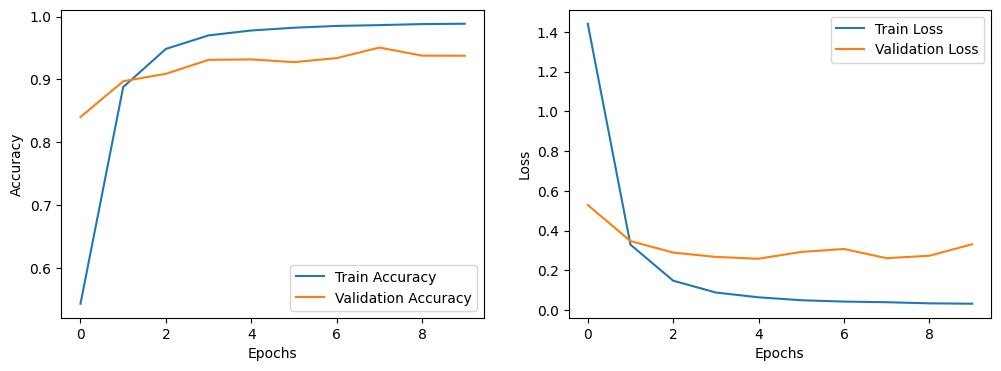

In [141]:
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Recherche d'hyper paramètre avec grid search 

In [142]:
# Définir le callback EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=0,
    restore_best_weights=True
)

model = KerasClassifier(
    model=create_cnn_model,
    epochs=10,  # Valeur par défaut que l'on pourra modifier via GridSearch
    batch_size=32,  # Valeur par défaut que l'on pourra modifier via GridSearch
    optimizer='adam',  # Valeur par défaut
    dropout_rate=0.5,  # Valeur par défaut
    verbose=0,  # Pour éviter trop de logs durant la recherche
    callbacks=[early_stopping_callback]
)

param_grid = {
    'model__neurons': [64, 128],
    'epochs': [10, 20],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.4, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

# Appliquer GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=3)

# Exécuter la recherche des meilleurs hyperparamètres
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

# Afficher les meilleurs paramètres trouvés et leur performance
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_:.4f}")


# Évaluer les performances sur les données de test
test_loss, test_acc = grid_result.best_estimator_.model_.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_acc:.4f}')

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END batch_size=32, dropout_rate=0.4, epochs=10, model__neurons=64, optimizer=rmsprop;, score=0.750 total time= 1.1min
[CV 1/3] END batch_size=32, dropout_rate=0.4, epochs=10, model__neurons=64, optimizer=adam;, score=0.823 total time= 1.2min
[CV 2/3] END batch_size=32, dropout_rate=0.4, epochs=10, model__neurons=128, optimizer=adam;, score=0.873 total time= 1.5min
[CV 1/3] END batch_size=32, dropout_rate=0.4, epochs=10, model__neurons=128, optimizer=adam;, score=0.899 total time= 1.5min
[CV 3/3] END batch_size=32, dropout_rate=0.4, epochs=10, model__neurons=64, optimizer=adam;, score=0.797 total time= 1.6min
[CV 2/3] END batch_size=32, dropout_rate=0.4, epochs=10, model__neurons=64, optimizer=adam;, score=0.793 total time= 1.6min
[CV 2/3] END batch_size=32, dropout_rate=0.4, epochs=10, model__neurons=64, optimizer=rmsprop;, score=0.717 total time= 1.6min
[CV 3/3] END batch_size=32, dropout_rate=0.4, epochs=10, model

### Augmentation D'image

Epoch 1/10
 25/858 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0479 - loss: 3.2217

/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.1316 - loss: 2.8693 - val_accuracy: 0.5353 - val_loss: 1.3784
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4934 - loss: 1.4943 - val_accuracy: 0.7358 - val_loss: 0.7250
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6398 - loss: 1.0265 - val_accuracy: 0.7939 - val_loss: 0.5466
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7130 - loss: 0.8162 - val_accuracy: 0.8613 - val_loss: 0.3749
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7520 - loss: 0.7034 - val_accuracy: 0.8627 - val_loss: 0.3622
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7924 - loss: 0.5894 - val_accuracy: 0.9148 - val_loss: 0.2520
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8229 - loss: 0.5013 - val_accuracy: 0.9193 - val_loss: 0.2155
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8382 - loss: 0.4505 - val_accuracy: 0.9586 - val_

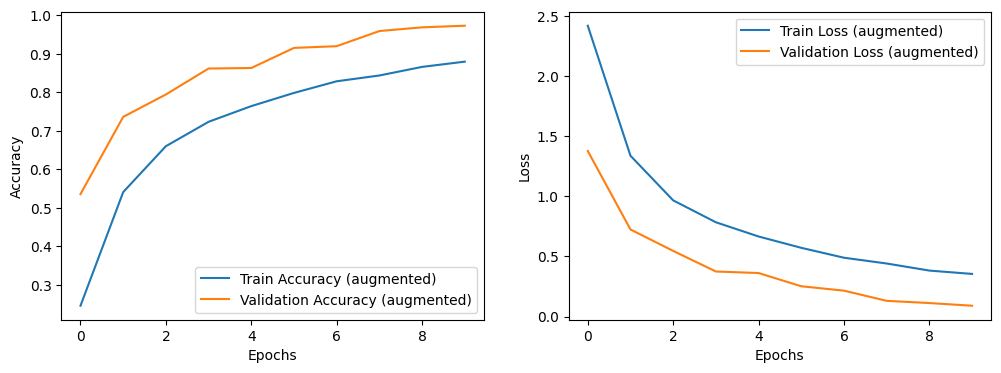

In [143]:
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotation aléatoire des images
    width_shift_range=0.1,  # Décalage horizontal
    height_shift_range=0.1, # Décalage vertical
    zoom_range=0.1,         # Zoom
    horizontal_flip=True,   # Retournement horizontal
    fill_mode='nearest'     # Remplissage des pixels manquants
)

datagen.fit(X_train)

# Définir le modèle CNN (déjà fait)
cnn_model = create_cnn_model()

# Entraîner le modèle avec les données augmentées
history_augmented = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

# Évaluer le modèle sur les données de test
test_loss_augmented, test_acc_augmented = cnn_model.evaluate(X_test, y_test)

print(f'Accuracy on test set with augmentation: {test_acc_augmented:.4f}')

# Tracer les courbes de performance (avec augmentation)
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy (augmented)')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy (augmented)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'], label='Train Loss (augmented)')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss (augmented)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

En Utilisant les mêmes paramètres avec l'augmentation des images on obtient des améliorations, ces améliorations étaient prévisible car cette technique est souvent recommandé quand on travail avec des datasets limités. Étant donné que les modèles de réseaux de neurones convolutifs (CNN) peuvent avoir une capacité de mémorisation élevée, exposer le modèle à une plus grande variété d'images rend les représentations apprises plus généralisées et robustes.

### Sauvegarde du meilleur model
 

In [149]:
# Sauvegarder le modèle entraîné avec les meilleurs paramètres
best_model = grid_result.best_estimator_.model_

# Créer un dossier de sauvegarde s'il n'existe pas
save_dir = './saved_models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Sauvegarder le modèle
model_path = os.path.join(save_dir, 'best_cnn_model.h5')
best_model.save(model_path)
print(f'Model saved to {model_path}')

# Évaluer le modèle sur les données de test
test_loss_augmented, test_acc_augmented = best_model.evaluate(X_test, y_test)
print(f'Accuracy on test set with best model: {test_acc_augmented:.4f}')

Model saved to ./saved_models/best_cnn_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4180 - loss: 5.3271
Accuracy on test set with best model: 0.4151


### Nos photos et notre meilleur model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


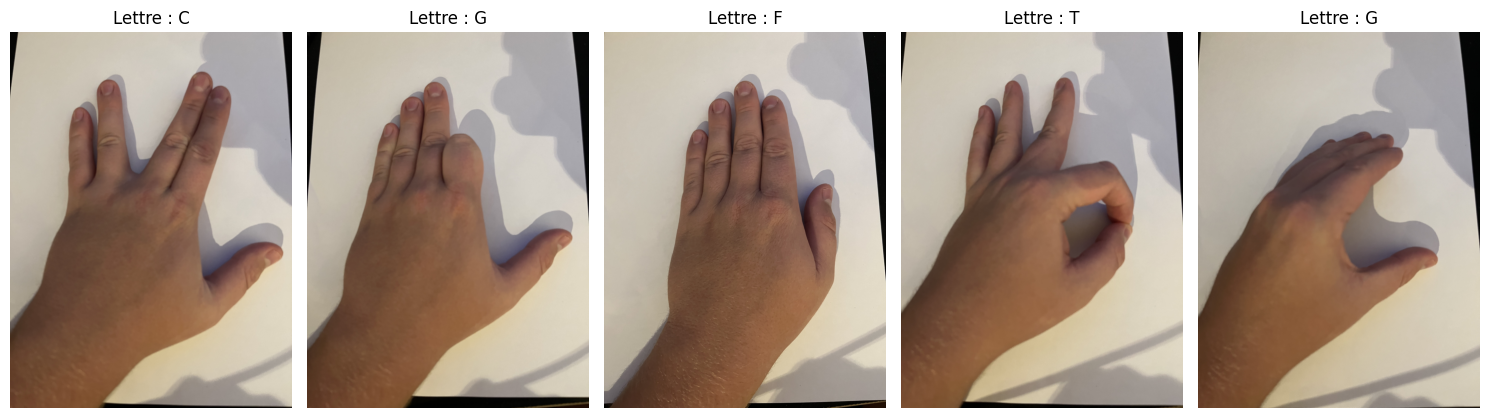

In [145]:
# Charger le meilleur modèle sauvegardé
#best_model = load_model('./saved_models/best_cnn_model.h5')
best_model = load_model('./checkpoints/best_model.keras')
# Fonction pour prétraiter les images (redimensionner, convertir en niveaux de gris, etc.)
def preprocess_image(image_path):
    # Charger l'image en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Vérifier si l'image a été correctement chargée
    if img is None:
        raise FileNotFoundError(f"Image non trouvée au chemin: {image_path}")
    
    # Redimensionner l'image à la taille 28x28 (ou la taille utilisée pour l'entraînement)
    img = cv2.resize(img, (28, 28))
    
    # Normaliser les pixels (valeurs entre 0 et 1)
    img = img.astype('float32') / 255.0
    
    # Ajouter une dimension pour correspondre au format attendu par le modèle (1, 28, 28, 1)
    img = np.expand_dims(img, axis=0)  # Ajouter la dimension du batch
    img = np.expand_dims(img, axis=-1)  # Ajouter la dimension du canal (niveaux de gris)
    
    return img

# Fonction pour prédire la lettre en langue des signes à partir d'une image
def predict_sign(image_path):
    # Prétraiter l'image
    processed_img = preprocess_image(image_path)
    
    # Faire une prédiction avec le modèle
    prediction = best_model.predict(processed_img)
    
    # Trouver l'indice de la classe prédite (qui correspond à une lettre)
    predicted_class = np.argmax(prediction, axis=1)
    
    return predicted_class

# Mapping des classes aux lettres de l'alphabet en langue des signes
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 
           'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

# Fonction pour afficher toutes les images et leurs prédictions sur une grille
def display_images_in_grid(directory, images_per_row=5):
    # Lister toutes les images dans le répertoire
    image_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpeg') or f.endswith('.jpg')]
    
    # Nombre total d'images
    total_images = len(image_paths)
    
    # Calculer le nombre de lignes pour la grille
    rows = total_images // images_per_row + int(total_images % images_per_row != 0)
    
    # Initialiser la figure
    fig, axes = plt.subplots(rows, images_per_row, figsize=(15, 15))
    axes = axes.flatten()  # Pour manipuler chaque subplot individuellement
    
    # Boucler sur chaque image et afficher avec la prédiction
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB pour l'affichage
        
        # Prédire la classe de l'image
        predicted_class = predict_sign(image_path)
        predicted_letter = classes[predicted_class[0]]
        
        # Afficher l'image avec la prédiction
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"Lettre : {predicted_letter}")
        axes[i].axis('off')  # Enlever les axes pour une meilleure visibilité
    
    # Enlever les axes vides (pour les sous-grilles non utilisées)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Spécifier le répertoire contenant les images
image_directory = './my_hand/'

# Afficher toutes les images et les prédictions sur une grille
display_images_in_grid(image_directory)



### Comparaison entre notre model et un model pré-entrainés disponible avec keras

In [146]:
# Redimensionner les images de 28x28 à 32x32 pour correspondre à l'entrée de VGG16
X_train_resized = tf.image.resize(X_train, [32, 32])
X_test_resized = tf.image.resize(X_test, [32, 32])

# Dupliquer le canal unique (1) à 3 canaux pour correspondre aux modèles ImageNet (input_shape=(32, 32, 3))
X_train_resized = tf.image.grayscale_to_rgb(X_train_resized)
X_test_resized = tf.image.grayscale_to_rgb(X_test_resized)

# Charger le modèle pré-entraîné VGG16 sans la partie fully-connected
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Créer le modèle avec des couches supplémentaires
model = models.Sequential()

# Ajouter le modèle pré-entrainé VGG16 sans sa dernière couche
model.add(base_model)

# Ajouter une couche de flattening
model.add(layers.Flatten())

# Ajouter une couche complètement connectée
model.add(layers.Dense(128, activation='relu'))

# Ajouter une couche de dropout pour éviter le surapprentissage
model.add(layers.Dropout(0.5))

# Ajouter la couche de sortie avec 25 neurones pour 25 classes (alphabet)
model.add(layers.Dense(25, activation='softmax'))

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
model.fit(X_train_resized, y_train, epochs=10, validation_data=(X_test_resized, y_test))

# Évaluer le modèle
test_loss, test_acc = model.evaluate(X_test_resized, y_test)
print(f"Test accuracy with pre-trained model: {test_acc:.4f}")


/var/folders/bf/8kwvc6j552g9y0_bwtnfhj500000gn/T/ipykernel_1678/3999698673.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - accuracy: 0.4926 - loss: 1.8477 - val_accuracy: 0.0909 - val_loss: 6.6083
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 57s 66ms/step - accuracy: 0.8240 - loss: 0.6285 - val_accuracy: 0.4028 - val_loss: 3.1925
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 57s 66ms/step - accuracy: 0.9298 - loss: 0.2584 - val_accuracy: 0.5849 - val_loss: 2.2631
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.9127 - loss: 0.3302 - val_accuracy: 0.4568 - val_loss: 2.5596
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.9250 - loss: 0.2819 - val_accuracy: 0.5814 - val_loss: 2.1247
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 65ms/step - accuracy: 0.9398 - loss: 0.2399 - val_accuracy: 0.1139 - val_loss: 5.0389
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.8907 - loss: 0.3938 - val_accuracy: 0.2358 - val_loss: 3.6875
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - accuracy: 0.9470 - loss: 0.1960 - 